In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Get the root directory: one level up from "trainers"
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)


In [2]:
import gc
import cv2
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter, defaultdict
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix 

import torch
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import autocast
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

# Import PyTorch Metric Learning
from pytorch_metric_learning import losses, miners, reducers, distances
from pytorch_metric_learning.utils import accuracy_calculator

import albumentations as A
from albumentations.pytorch import ToTensorV2 #np.array -> torch.tensor (B, 3, H, W)
import timm

from utils.dataset import TripletDataset



In [3]:
num_classes = 3
root_dir = '../datasets/'
csv_train_file = 'train_data_with_folds.csv'
class_list = ['normal', 'preplus', 'plus']
label_dict = {cls: i for i, cls in enumerate(class_list)}

df = pd.read_csv(os.path.join(root_dir, csv_train_file))

In [4]:
def get_transforms(image_size):
    transforms_train = A.Compose([
        A.Resize(image_size, image_size),
        # A.ImageCompression(quality_lower=80, quality_upper=100, p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.5),
        # A.Flip(p=0.5),
        # A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.CoarseDropout(num_holes_range=(1,1), hole_height_range=(8, 32), hole_width_range=(8, 32), p=0.25),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    transforms_val = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    return transforms_train, transforms_val

class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    """
    Args:
      tensor (Tensor): Tensor image of size (C, H, W) to be normalized'
    Returns:
      Tensor: Normalized image
    """
    for t, m, s in zip(tensor, self.mean, self.std):
      t.mul_(s).add_(m)
      #The normalize code -> t.sub_(m).div_(s)
    return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

def get_sampler(dataset): # WeightedRandomSampler
    labels = [dataset.dataset[idx][1] for idx in range(len(dataset))]
    class_counts = np.bincount(labels, minlength=num_classes)
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# Modified model for embedding output
class EmbeddingModel(nn.Module):
    def __init__(self, num_classes, backbone_name, embedding_size=512):
        super().__init__()
        self.n_classes = num_classes
        self.embedding_size = embedding_size
        
        # Use ResNet152 as the backbone with num_classes=0 to remove classifier head
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes=0  # Remove classifier head
        )
        
        # Get the feature dimension from backbone
        self.in_features = self.backbone.num_features  # Works with num_classes=0
        
        # Add embedding layer
        self.embedding = nn.Sequential(
            nn.Linear(self.in_features, self.embedding_size),
            nn.BatchNorm1d(self.embedding_size),
            nn.ReLU(inplace=True)
        )
        
        # Classifier layer (for regular classification task)
        self.classifier = nn.Linear(self.embedding_size, self.n_classes)

    def forward(self, x, return_embeddings=False):
        features = self.backbone(x)  # Returns a single feature vector
        embeddings = self.embedding(features)
        
        if return_embeddings:
            return embeddings
        
        logits = self.classifier(embeddings)
        return logits, embeddings

# Plotting function
def plot_fold_history(fold, history, run_dir):
    epochs = list(range(1, len(history['train_loss']) + 1))
    plt.figure(figsize=(15, 5))
    
    # Plot auc
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_auc'], '-o', label='Train AUC', color='skyblue')
    plt.plot(epochs, history['val_auc'], '-o', label='Val AUC', color='lightcoral')
    plt.scatter(history['best_val_auc_epoch'], history['best_val_auc'], s=200, color='lightcoral')
    plt.text(history['best_val_auc_epoch'], history['best_val_auc'], f'max {history["best_val_auc"]:.4f}', size=12)
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title(f'Fold {fold} Auc')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], '-o', label='Train Loss', color='skyblue')
    plt.plot(epochs, history['val_loss'], '-o', label='Val Loss', color='lightcoral')
    plt.plot(epochs, history['triplet_loss'], '-o', label='Triplet Loss', color='green')
    plt.scatter(history['best_val_loss_epoch'], history['best_val_loss'], s=200, color='lightcoral')
    plt.text(history['best_val_loss_epoch'], history['best_val_loss'], f'min {history["best_val_loss"]:.4f}', size=12)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold} Loss')
    plt.legend()
    
    plt.tight_layout()
    plot_path = os.path.join(run_dir, f"fold{fold}_history.png")
    plt.savefig(plot_path)
    print(f"History plot saved: {plot_path}")
    plt.show()

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class EarlyStopper:
    def __init__(self, min_delta=0, patience=1):
        self.min_delta = min_delta
        self.patience = patience
        self.max_val_auc = -float('inf')
        self.count = 0
        
    def early_stop(self, val_auc):
        if self.max_val_auc < val_auc:
            self.max_val_auc = val_auc
            self.count = 0
        elif self.max_val_auc > val_auc + self.min_delta:
            self.count += 1
            if self.count >= self.patience:
                return True
        return False
        
# Custom GradualWarmupSchedulerV2
class GradualWarmupSchedulerV2:
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.optimizer = optimizer
        self.multiplier = multiplier
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        self.last_epoch = -1
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]
    
    def step(self, epoch=None):
        if epoch is None:
            self.last_epoch += 1
        else:
            self.last_epoch = epoch
        
        if self.last_epoch <= self.total_epoch:
            # Warmup phase
            for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
                param_group['lr'] = lr
        elif self.after_scheduler:
            # Transition to after_scheduler
            if not self.finished:
                self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                self.finished = True
            self.after_scheduler.step(self.last_epoch - self.total_epoch)
    
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [5]:
def train_epoch(model, loader, optimizer, criterion, triplet_loss, miner, device):
    train_loss_meter = AverageMeter()
    triplet_loss_meter = AverageMeter()
    ce_loss_meter = AverageMeter()
    model.train()
    
    PROBS = []
    TARGETS = []
    
    for img, label in tqdm(loader, desc='Training'):
      
        optimizer.zero_grad()
        inputs = img.to(device)
        targets = label.to(device)
        
        # Get both logits and embeddings
        logits, embeddings = model(inputs)
        
        # Calculate classification loss
        ce_loss = criterion(logits, targets)
        
        # Calculate triplet loss with hard mining
        hard_pairs = miner(embeddings, targets)
        trip_loss = triplet_loss(embeddings, targets, hard_pairs)
        
        # Combine losses
        loss = ce_loss + trip_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss_meter.update(loss.item(), inputs.size(0))
        ce_loss_meter.update(ce_loss.item(), inputs.size(0))
        triplet_loss_meter.update(trip_loss.item() if trip_loss != 0 else 0, inputs.size(0))
        
        with torch.no_grad():
            probs = F.softmax(logits.float(), dim=1).cpu().numpy()
            PROBS.append(probs)
            TARGETS.append(targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    PROBS = np.concatenate(PROBS)
    TARGETS = np.concatenate(TARGETS)

    if not np.allclose(PROBS.sum(axis=1), 1.0, atol=1e-5):
        print("PROBS not summing to 1!")
    if np.any(TARGETS < 0) or np.any(TARGETS >= num_classes):
        print(f"Invalid TARGETS values: {TARGETS}")

    # Compute AUC over entire epoch
    try:
        train_auc = roc_auc_score(y_true=TARGETS, y_score=PROBS, multi_class='ovr')
    except ValueError as e:
        print(f"Sample of PROBS: {PROBS[0]}, sum: {PROBS.sum(axis=1)}")
        print(f"Error: {e}")
        train_auc = 0.0
        
    return train_loss_meter.avg, train_auc, triplet_loss_meter.avg, ce_loss_meter.avg

# Validation epoch
def val_epoch(model, loader, criterion, triplet_loss, miner, device):
    model.eval()
    val_loss_meter = AverageMeter()
    triplet_loss_meter = AverageMeter()
    ce_loss_meter = AverageMeter()
    
    PROBS = []
    TARGETS = []
    
    with torch.no_grad():
        for img, label in loader:
            inputs = img.to(device)
            targets = label.to(device)

            logits, embeddings = model(inputs)
            
            # Calculate classification loss
            ce_loss = criterion(logits, targets)
            
            # Calculate triplet loss with hard mining
            hard_pairs = miner(embeddings, targets)
            trip_loss = triplet_loss(embeddings, targets, hard_pairs)
            
            # Combine losses
            loss = ce_loss + trip_loss
            
            val_loss_meter.update(loss.item(), inputs.size(0))
            ce_loss_meter.update(ce_loss.item(), inputs.size(0))
            triplet_loss_meter.update(trip_loss.item() if trip_loss != 0 else 0, inputs.size(0))
            
            probs = F.softmax(logits.float(), dim=1).cpu().numpy()
            PROBS.append(probs)
            TARGETS.append(targets.cpu().numpy())
    
    PROBS = np.concatenate(PROBS)
    TARGETS = np.concatenate(TARGETS)
    
    try:
        val_auc = roc_auc_score(TARGETS, PROBS, multi_class='ovr')
    except ValueError as e:
        print(f"Val AUC failed: {e}, Unique targets: {np.unique(TARGETS)}, Probs shape: {PROBS.shape}")
        val_auc = 0.0
    
    return val_loss_meter.avg, val_auc, triplet_loss_meter.avg, ce_loss_meter.avg

In [6]:
def run(fold, df, root_dir, transforms_train, transforms_val, num_workers, n_epochs, device, batch_size, lr, run_dir, backbone_name):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df = df[df['fold'] == fold].reset_index(drop=True)

    # Datasets
    train_ds = TripletDataset(root_dir, train_df,'train', transform=transforms_train)
    val_ds = TripletDataset(root_dir, val_df,'train', transform=transforms_val)
    
    # Data loaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True, 
        pin_memory=True, 
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False, 
        pin_memory=True, 
    )

    # Model, optimizer, criterion
    model = EmbeddingModel(num_classes,backbone_name, 512).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    
    # Classification loss
    criterion = nn.CrossEntropyLoss()
    
    # Distance function for triplet loss
    distance = distances.CosineSimilarity()
    
    # Batch hard miner for triplet loss
    miner = miners.BatchEasyHardMiner(
        pos_strategy="easy",  # hardest positive
        neg_strategy="hard",  # hardest negative
        distance=distance
    )
    
    # Triplet loss with margin
    triplet_loss = losses.TripletMarginLoss(
        margin=0.1,
        distance=distance,
        reducer=reducers.AvgNonZeroReducer()
    )

    # Learning rate scheduler
    scheduler_cosine = CosineAnnealingWarmRestarts(optimizer, T_0=10)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=2, after_scheduler=scheduler_cosine)

    # History tracking
    history = {
        'train_loss': [], 'val_loss': [],
        'train_auc': [], 'val_auc': [],
        'triplet_loss': [], 'ce_loss': [],
        'learning_rates': [],
        'best_val_auc': 0, 'best_val_auc_epoch': 0,
        'best_val_loss': float('inf'), 'best_val_loss_epoch': 0
    }


    print(f"Fold {fold}: =========================================")
    
    early_stopping_active = False
    # es = EarlyStopper(min_delta=1e-3, patience=2)
    best_model_state_dict = None
    best_model_filename = None

    for epoch in range(1, n_epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        print(f"\nEP {epoch}/{n_epochs} (LR: {current_lr:.6f}):")
        train_loss, train_auc, train_triplet_loss, train_ce_loss = train_epoch(model, train_loader, optimizer, criterion, triplet_loss, miner, device)
        val_loss, val_auc, val_triplet_loss, val_ce_loss = val_epoch(model, val_loader, criterion, triplet_loss, miner, device)
        
        print(f"Train AUC: {train_auc:.4f}, CE Loss: {train_ce_loss:.4f}, Triplet Loss: {train_triplet_loss:.4f}")
        print(f"Val AUC: {val_auc:.4f}, CE Loss: {val_ce_loss:.4f}, Triplet Loss: {val_triplet_loss:.4f}")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)
        history['triplet_loss'].append(train_triplet_loss)
        history['ce_loss'].append(train_ce_loss)
        
        if val_auc > history['best_val_auc']:
            history['best_val_auc'] = val_auc
            history['best_val_auc_epoch'] = epoch
            best_model_state_dict = model.state_dict()
            # checkpoint_path = os.path.join(run_dir, f"fold{fold}_best_auc{val_auc:.4f}_ep{epoch}.pth")
            # torch.save(model.state_dict(), checkpoint_path)
            print(f"New best AUC: {val_auc:.4f} at epoch {epoch}.")
        
        if val_loss < history['best_val_loss']:
            history['best_val_loss'] = val_loss
            history['best_val_loss_epoch'] = epoch
        
        # Step the scheduler (use warmup scheduler during warmup, then cosine)
        if epoch <= scheduler_warmup.total_epoch:
            scheduler_warmup.step()
        else:
            scheduler_cosine.step()
            
        if epoch == scheduler_warmup.total_epoch:
            early_stopping_active = True
            # Reset early stopper to forget the potentially misleading high scores during warmup
            es = EarlyStopper(min_delta=1e-4, patience=5)
            print("Warmup complete. Early stopping now active.")
        
        # Only check early stopping if it's active
        if early_stopping_active:
            if es.early_stop(val_auc):
                print(f"Early stopping triggered at epoch {epoch}")
                break
    
    # Save the final model and best model
    if best_model_state_dict is not None:
        best_model_filename = os.path.join(run_dir, f"fold{fold}_best_auc{history['best_val_auc']:.4f}_ep{history['best_val_auc_epoch']}.pth")
        torch.save(best_model_state_dict, best_model_filename)
        print(f"Best model saved: {best_model_filename}")

    final_checkpoint_path = os.path.join(run_dir, f"fold{fold}_final.pth")
    torch.save(model.state_dict(), final_checkpoint_path)
    print(f"Final model saved: {final_checkpoint_path}")

    # Plot history
    plot_fold_history(fold, history, run_dir)
    
    # Compute OOF predictions after training
    best_model_path = os.path.join(run_dir, f"fold{fold}_best_auc{history['best_val_auc']:.4f}_ep{history['best_val_auc_epoch']}.pth")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    oof_preds = []
    oof_targets = []
    oof_embeddings = []
    with torch.no_grad():
        for img, label in val_loader:
            inputs = img.to(device)
            targets = label.to(device)
            logits, embeddings = model(inputs)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            oof_preds.append(probs)
            oof_targets.append(targets.cpu().numpy())
            oof_embeddings.append(embeddings.cpu().numpy())
    
    oof_preds = np.concatenate(oof_preds)
    oof_targets = np.concatenate(oof_targets)
    oof_embeddings = np.concatenate(oof_embeddings)
    
    # Save embeddings for later visualization or analysis
    embeddings_path = os.path.join(run_dir, f'fold_{fold}_embeddings.npy')
    np.save(embeddings_path, oof_embeddings)
    
    oof_names = val_df['path'].values
    oof_folds = np.full(len(oof_targets), fold)
    return oof_preds, oof_targets, oof_names, oof_folds, oof_embeddings

# Visualization function for embeddings using t-SNE
def visualize_embeddings(embeddings, labels, title="t-SNE Visualization of Embeddings", run_dir=None):
    from sklearn.manifold import TSNE
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for class_idx in np.unique(labels):
        plt.scatter(
            embeddings_2d[labels == class_idx, 0],
            embeddings_2d[labels == class_idx, 1],
            label=f'Class {class_idx}'
        )
    
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join(run_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(plot_path)
    plt.show()


Num workers = 0
Checkpoints will be saved in: ../checkpoints\run1
Fold 0: =========================================

EP 1/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:14<00:00,  2.07it/s]


Train AUC: 0.7546, CE Loss: 0.8597, Triplet Loss: 0.1311
Val AUC: 0.8042, CE Loss: 0.8815, Triplet Loss: 0.0061
New best AUC: 0.8042 at epoch 1.

EP 2/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.8509, CE Loss: 0.6608, Triplet Loss: 0.1300
Val AUC: 0.8886, CE Loss: 0.5558, Triplet Loss: 0.0051
New best AUC: 0.8886 at epoch 2.
Warmup complete. Early stopping now active.

EP 3/50 (LR: 0.001650):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.7687, CE Loss: 0.8398, Triplet Loss: 0.1816
Val AUC: 0.8567, CE Loss: 0.6544, Triplet Loss: 0.0087

EP 4/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.8618, CE Loss: 0.6330, Triplet Loss: 0.1647
Val AUC: 0.9050, CE Loss: 0.5297, Triplet Loss: 0.0099
New best AUC: 0.9050 at epoch 4.

EP 5/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.09it/s]


Train AUC: 0.8973, CE Loss: 0.5564, Triplet Loss: 0.1559
Val AUC: 0.9333, CE Loss: 0.4441, Triplet Loss: 0.0053
New best AUC: 0.9333 at epoch 5.

EP 6/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.9283, CE Loss: 0.4684, Triplet Loss: 0.1421
Val AUC: 0.9414, CE Loss: 0.4172, Triplet Loss: 0.0109
New best AUC: 0.9414 at epoch 6.

EP 7/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.9345, CE Loss: 0.4438, Triplet Loss: 0.1229
Val AUC: 0.9427, CE Loss: 0.4085, Triplet Loss: 0.0025
New best AUC: 0.9427 at epoch 7.

EP 8/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.9565, CE Loss: 0.3697, Triplet Loss: 0.1174
Val AUC: 0.9580, CE Loss: 0.3570, Triplet Loss: 0.0042
New best AUC: 0.9580 at epoch 8.

EP 9/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9625, CE Loss: 0.3422, Triplet Loss: 0.1132
Val AUC: 0.9613, CE Loss: 0.3473, Triplet Loss: 0.0113
New best AUC: 0.9613 at epoch 9.

EP 10/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9688, CE Loss: 0.3266, Triplet Loss: 0.1029
Val AUC: 0.9677, CE Loss: 0.3112, Triplet Loss: 0.0032
New best AUC: 0.9677 at epoch 10.

EP 11/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9722, CE Loss: 0.2993, Triplet Loss: 0.1110
Val AUC: 0.9663, CE Loss: 0.3176, Triplet Loss: 0.0034

EP 12/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9727, CE Loss: 0.3018, Triplet Loss: 0.0875
Val AUC: 0.9660, CE Loss: 0.3143, Triplet Loss: 0.0039

EP 13/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9547, CE Loss: 0.3737, Triplet Loss: 0.1229
Val AUC: 0.9583, CE Loss: 0.3737, Triplet Loss: 0.0022

EP 14/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9620, CE Loss: 0.3413, Triplet Loss: 0.1190
Val AUC: 0.9548, CE Loss: 0.3944, Triplet Loss: 0.0097

EP 15/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9556, CE Loss: 0.3698, Triplet Loss: 0.1120
Val AUC: 0.9735, CE Loss: 0.3027, Triplet Loss: 0.0019
New best AUC: 0.9735 at epoch 15.

EP 16/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9719, CE Loss: 0.2948, Triplet Loss: 0.1036
Val AUC: 0.9758, CE Loss: 0.2864, Triplet Loss: 0.0000
New best AUC: 0.9758 at epoch 16.

EP 17/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9815, CE Loss: 0.2434, Triplet Loss: 0.0683
Val AUC: 0.9752, CE Loss: 0.3015, Triplet Loss: 0.0073

EP 18/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9845, CE Loss: 0.2193, Triplet Loss: 0.0688
Val AUC: 0.9858, CE Loss: 0.2195, Triplet Loss: 0.0022
New best AUC: 0.9858 at epoch 18.

EP 19/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9905, CE Loss: 0.1785, Triplet Loss: 0.0566
Val AUC: 0.9905, CE Loss: 0.1882, Triplet Loss: 0.0006
New best AUC: 0.9905 at epoch 19.

EP 20/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9916, CE Loss: 0.1662, Triplet Loss: 0.0518
Val AUC: 0.9891, CE Loss: 0.1987, Triplet Loss: 0.0019

EP 21/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9931, CE Loss: 0.1476, Triplet Loss: 0.0508
Val AUC: 0.9905, CE Loss: 0.1766, Triplet Loss: 0.0044
New best AUC: 0.9905 at epoch 21.

EP 22/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9955, CE Loss: 0.1261, Triplet Loss: 0.0381
Val AUC: 0.9897, CE Loss: 0.2054, Triplet Loss: 0.0058

EP 23/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9854, CE Loss: 0.2073, Triplet Loss: 0.0692
Val AUC: 0.9798, CE Loss: 0.2675, Triplet Loss: 0.0007

EP 24/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9792, CE Loss: 0.2552, Triplet Loss: 0.0927
Val AUC: 0.9682, CE Loss: 0.3304, Triplet Loss: 0.0027

EP 25/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9804, CE Loss: 0.2425, Triplet Loss: 0.0786
Val AUC: 0.9746, CE Loss: 0.3035, Triplet Loss: 0.0010

EP 26/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9815, CE Loss: 0.2339, Triplet Loss: 0.0672
Val AUC: 0.9839, CE Loss: 0.2267, Triplet Loss: 0.0000
Early stopping triggered at epoch 26
Best model saved: ../checkpoints\run1\fold0_best_auc0.9905_ep21.pth
Final model saved: ../checkpoints\run1\fold0_final.pth
History plot saved: ../checkpoints\run1\fold0_history.png


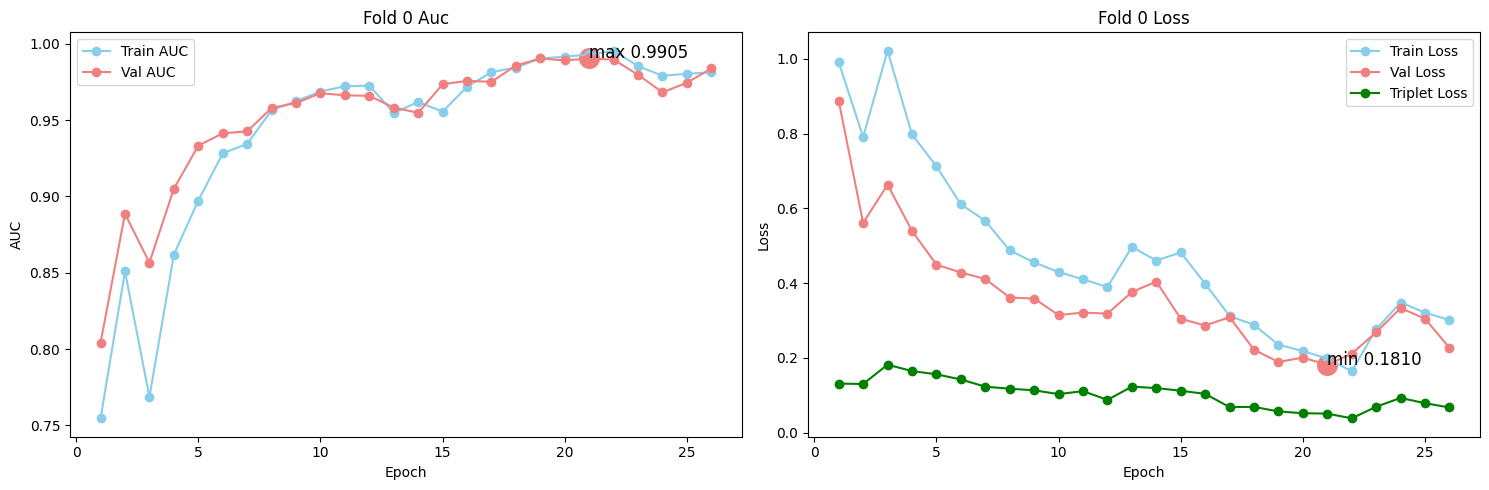

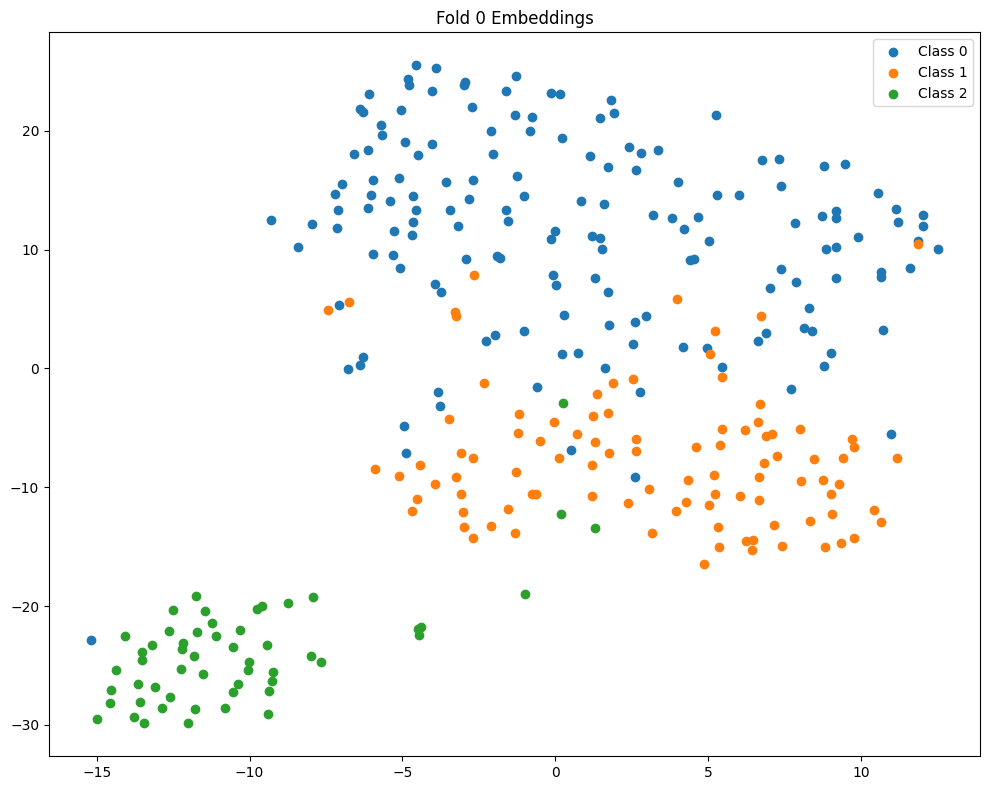

Fold 1: =========================================

EP 1/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.7383, CE Loss: 0.8891, Triplet Loss: 0.1312
Val AUC: 0.8341, CE Loss: 0.6948, Triplet Loss: 0.0053
New best AUC: 0.8341 at epoch 1.

EP 2/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.8442, CE Loss: 0.6805, Triplet Loss: 0.1198
Val AUC: 0.8834, CE Loss: 0.6761, Triplet Loss: 0.0034
New best AUC: 0.8834 at epoch 2.
Warmup complete. Early stopping now active.

EP 3/50 (LR: 0.001650):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.7377, CE Loss: 0.8968, Triplet Loss: 0.2451
Val AUC: 0.7990, CE Loss: 0.7605, Triplet Loss: 0.0061

EP 4/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.7779, CE Loss: 0.7993, Triplet Loss: 0.2318
Val AUC: 0.8719, CE Loss: 0.6278, Triplet Loss: 0.0039

EP 5/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.8332, CE Loss: 0.6901, Triplet Loss: 0.1866
Val AUC: 0.9041, CE Loss: 0.5546, Triplet Loss: 0.0051
New best AUC: 0.9041 at epoch 5.

EP 6/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.8730, CE Loss: 0.6167, Triplet Loss: 0.1747
Val AUC: 0.9194, CE Loss: 0.4854, Triplet Loss: 0.0170
New best AUC: 0.9194 at epoch 6.

EP 7/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.8925, CE Loss: 0.5581, Triplet Loss: 0.1562
Val AUC: 0.9239, CE Loss: 0.4781, Triplet Loss: 0.0028
New best AUC: 0.9239 at epoch 7.

EP 8/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9056, CE Loss: 0.5285, Triplet Loss: 0.1554
Val AUC: 0.9389, CE Loss: 0.4195, Triplet Loss: 0.0062
New best AUC: 0.9389 at epoch 8.

EP 9/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9105, CE Loss: 0.5122, Triplet Loss: 0.1380
Val AUC: 0.9495, CE Loss: 0.4177, Triplet Loss: 0.0060
New best AUC: 0.9495 at epoch 9.

EP 10/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9325, CE Loss: 0.4551, Triplet Loss: 0.1283
Val AUC: 0.9547, CE Loss: 0.3814, Triplet Loss: 0.0000
New best AUC: 0.9547 at epoch 10.

EP 11/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9428, CE Loss: 0.4265, Triplet Loss: 0.1270
Val AUC: 0.9523, CE Loss: 0.3755, Triplet Loss: 0.0012

EP 12/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9420, CE Loss: 0.4311, Triplet Loss: 0.1194
Val AUC: 0.9547, CE Loss: 0.3674, Triplet Loss: 0.0022
New best AUC: 0.9547 at epoch 12.

EP 13/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9249, CE Loss: 0.4728, Triplet Loss: 0.1439
Val AUC: 0.9381, CE Loss: 0.4425, Triplet Loss: 0.0043

EP 14/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9143, CE Loss: 0.5107, Triplet Loss: 0.1454
Val AUC: 0.9236, CE Loss: 0.4575, Triplet Loss: 0.0036

EP 15/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9289, CE Loss: 0.4612, Triplet Loss: 0.1447
Val AUC: 0.9484, CE Loss: 0.3991, Triplet Loss: 0.0011

EP 16/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9495, CE Loss: 0.3859, Triplet Loss: 0.1255
Val AUC: 0.9679, CE Loss: 0.3239, Triplet Loss: 0.0018
New best AUC: 0.9679 at epoch 16.

EP 17/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9497, CE Loss: 0.3965, Triplet Loss: 0.1301
Val AUC: 0.9716, CE Loss: 0.2999, Triplet Loss: 0.0025
New best AUC: 0.9716 at epoch 17.

EP 18/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9649, CE Loss: 0.3287, Triplet Loss: 0.1045
Val AUC: 0.9737, CE Loss: 0.2835, Triplet Loss: 0.0000
New best AUC: 0.9737 at epoch 18.

EP 19/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9748, CE Loss: 0.2803, Triplet Loss: 0.0837
Val AUC: 0.9786, CE Loss: 0.2562, Triplet Loss: 0.0000
New best AUC: 0.9786 at epoch 19.

EP 20/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9773, CE Loss: 0.2655, Triplet Loss: 0.0873
Val AUC: 0.9802, CE Loss: 0.2546, Triplet Loss: 0.0000
New best AUC: 0.9802 at epoch 20.

EP 21/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9831, CE Loss: 0.2295, Triplet Loss: 0.0691
Val AUC: 0.9806, CE Loss: 0.2455, Triplet Loss: 0.0002
New best AUC: 0.9806 at epoch 21.

EP 22/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9867, CE Loss: 0.2047, Triplet Loss: 0.0624
Val AUC: 0.9813, CE Loss: 0.2386, Triplet Loss: 0.0012
New best AUC: 0.9813 at epoch 22.

EP 23/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9623, CE Loss: 0.3356, Triplet Loss: 0.0962
Val AUC: 0.9514, CE Loss: 0.4015, Triplet Loss: 0.0032

EP 24/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9670, CE Loss: 0.3168, Triplet Loss: 0.1147
Val AUC: 0.9688, CE Loss: 0.3139, Triplet Loss: 0.0003

EP 25/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9664, CE Loss: 0.3200, Triplet Loss: 0.1040
Val AUC: 0.9587, CE Loss: 0.3504, Triplet Loss: 0.0093

EP 26/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9766, CE Loss: 0.2654, Triplet Loss: 0.1058
Val AUC: 0.9589, CE Loss: 0.3791, Triplet Loss: 0.0034

EP 27/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9816, CE Loss: 0.2303, Triplet Loss: 0.0855
Val AUC: 0.9669, CE Loss: 0.3560, Triplet Loss: 0.0014
Early stopping triggered at epoch 27
Best model saved: ../checkpoints\run1\fold1_best_auc0.9813_ep22.pth
Final model saved: ../checkpoints\run1\fold1_final.pth
History plot saved: ../checkpoints\run1\fold1_history.png


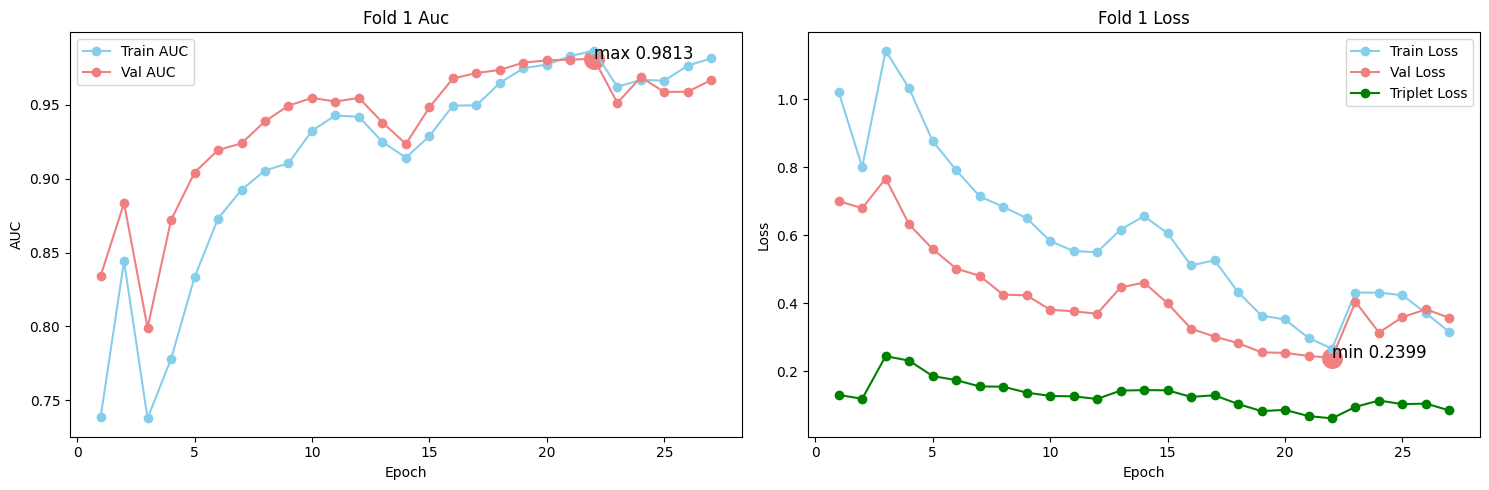

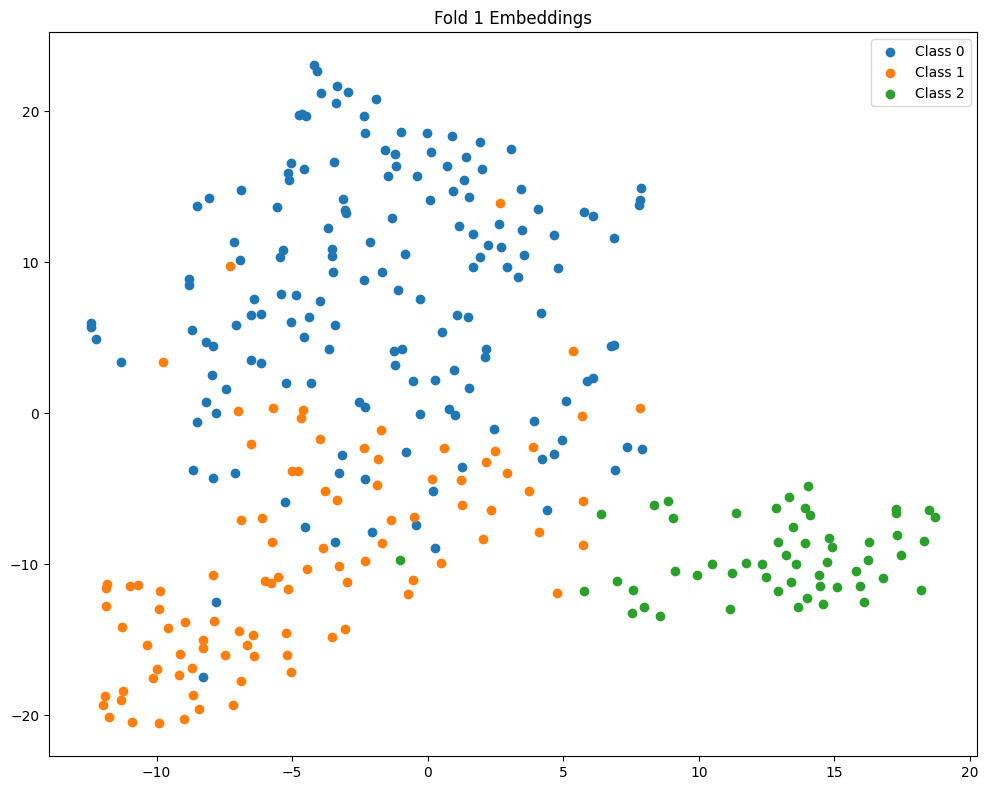

Fold 2: =========================================

EP 1/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.7397, CE Loss: 0.8808, Triplet Loss: 0.1252
Val AUC: 0.8741, CE Loss: 0.6939, Triplet Loss: 0.0025
New best AUC: 0.8741 at epoch 1.

EP 2/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.8621, CE Loss: 0.6385, Triplet Loss: 0.1234
Val AUC: 0.9027, CE Loss: 0.5279, Triplet Loss: 0.0003
New best AUC: 0.9027 at epoch 2.
Warmup complete. Early stopping now active.

EP 3/50 (LR: 0.001650):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.7851, CE Loss: 0.8153, Triplet Loss: 0.1981
Val AUC: 0.8572, CE Loss: 0.7985, Triplet Loss: 0.0057

EP 4/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.8711, CE Loss: 0.6225, Triplet Loss: 0.1564
Val AUC: 0.9448, CE Loss: 0.4330, Triplet Loss: 0.0000
New best AUC: 0.9448 at epoch 4.

EP 5/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9126, CE Loss: 0.5190, Triplet Loss: 0.1390
Val AUC: 0.9494, CE Loss: 0.3890, Triplet Loss: 0.0000
New best AUC: 0.9494 at epoch 5.

EP 6/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9380, CE Loss: 0.4347, Triplet Loss: 0.1399
Val AUC: 0.9655, CE Loss: 0.3428, Triplet Loss: 0.0000
New best AUC: 0.9655 at epoch 6.

EP 7/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9513, CE Loss: 0.3862, Triplet Loss: 0.1169
Val AUC: 0.9715, CE Loss: 0.3337, Triplet Loss: 0.0029
New best AUC: 0.9715 at epoch 7.

EP 8/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9581, CE Loss: 0.3561, Triplet Loss: 0.1122
Val AUC: 0.9653, CE Loss: 0.3048, Triplet Loss: 0.0011

EP 9/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9743, CE Loss: 0.2926, Triplet Loss: 0.0854
Val AUC: 0.9770, CE Loss: 0.2432, Triplet Loss: 0.0025
New best AUC: 0.9770 at epoch 9.

EP 10/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9758, CE Loss: 0.2748, Triplet Loss: 0.0853
Val AUC: 0.9768, CE Loss: 0.2612, Triplet Loss: 0.0014

EP 11/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9837, CE Loss: 0.2399, Triplet Loss: 0.0733
Val AUC: 0.9782, CE Loss: 0.2373, Triplet Loss: 0.0000
New best AUC: 0.9782 at epoch 11.

EP 12/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9817, CE Loss: 0.2406, Triplet Loss: 0.0705
Val AUC: 0.9794, CE Loss: 0.2365, Triplet Loss: 0.0000
New best AUC: 0.9794 at epoch 12.

EP 13/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9608, CE Loss: 0.3456, Triplet Loss: 0.1025
Val AUC: 0.9739, CE Loss: 0.2817, Triplet Loss: 0.0034

EP 14/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9686, CE Loss: 0.3030, Triplet Loss: 0.1077
Val AUC: 0.9691, CE Loss: 0.2814, Triplet Loss: 0.0000

EP 15/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9716, CE Loss: 0.2907, Triplet Loss: 0.0990
Val AUC: 0.9773, CE Loss: 0.2601, Triplet Loss: 0.0062

EP 16/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9799, CE Loss: 0.2475, Triplet Loss: 0.0860
Val AUC: 0.9851, CE Loss: 0.2027, Triplet Loss: 0.0054
New best AUC: 0.9851 at epoch 16.

EP 17/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9759, CE Loss: 0.2684, Triplet Loss: 0.0815
Val AUC: 0.9871, CE Loss: 0.2289, Triplet Loss: 0.0000
New best AUC: 0.9871 at epoch 17.

EP 18/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9867, CE Loss: 0.1955, Triplet Loss: 0.0659
Val AUC: 0.9848, CE Loss: 0.2104, Triplet Loss: 0.0038

EP 19/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9914, CE Loss: 0.1676, Triplet Loss: 0.0558
Val AUC: 0.9867, CE Loss: 0.1831, Triplet Loss: 0.0000

EP 20/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9932, CE Loss: 0.1480, Triplet Loss: 0.0480
Val AUC: 0.9877, CE Loss: 0.1703, Triplet Loss: 0.0075
New best AUC: 0.9877 at epoch 20.

EP 21/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9937, CE Loss: 0.1329, Triplet Loss: 0.0374
Val AUC: 0.9868, CE Loss: 0.1710, Triplet Loss: 0.0017

EP 22/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9925, CE Loss: 0.1444, Triplet Loss: 0.0373
Val AUC: 0.9883, CE Loss: 0.1723, Triplet Loss: 0.0000
New best AUC: 0.9883 at epoch 22.

EP 23/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9901, CE Loss: 0.1743, Triplet Loss: 0.0640
Val AUC: 0.9771, CE Loss: 0.2496, Triplet Loss: 0.0000

EP 24/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9773, CE Loss: 0.2661, Triplet Loss: 0.0912
Val AUC: 0.9737, CE Loss: 0.3133, Triplet Loss: 0.0000

EP 25/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9846, CE Loss: 0.2110, Triplet Loss: 0.0660
Val AUC: 0.9818, CE Loss: 0.2321, Triplet Loss: 0.0034

EP 26/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9889, CE Loss: 0.1777, Triplet Loss: 0.0665
Val AUC: 0.9816, CE Loss: 0.2331, Triplet Loss: 0.0048

EP 27/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9917, CE Loss: 0.1509, Triplet Loss: 0.0537
Val AUC: 0.9858, CE Loss: 0.1782, Triplet Loss: 0.0004
Early stopping triggered at epoch 27
Best model saved: ../checkpoints\run1\fold2_best_auc0.9883_ep22.pth
Final model saved: ../checkpoints\run1\fold2_final.pth
History plot saved: ../checkpoints\run1\fold2_history.png


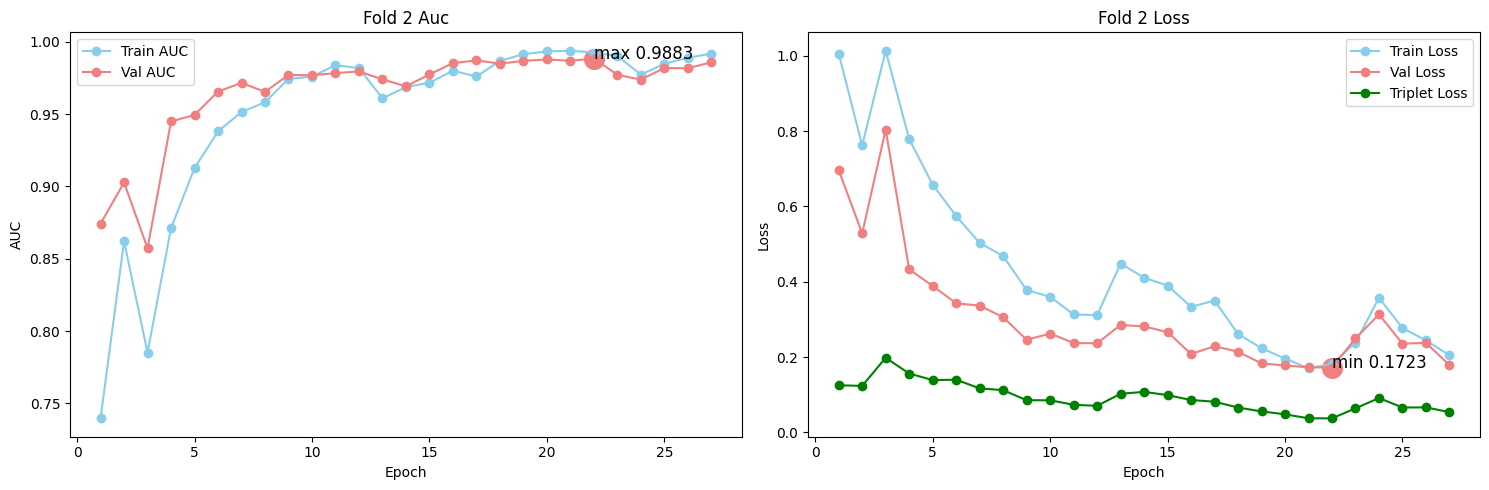

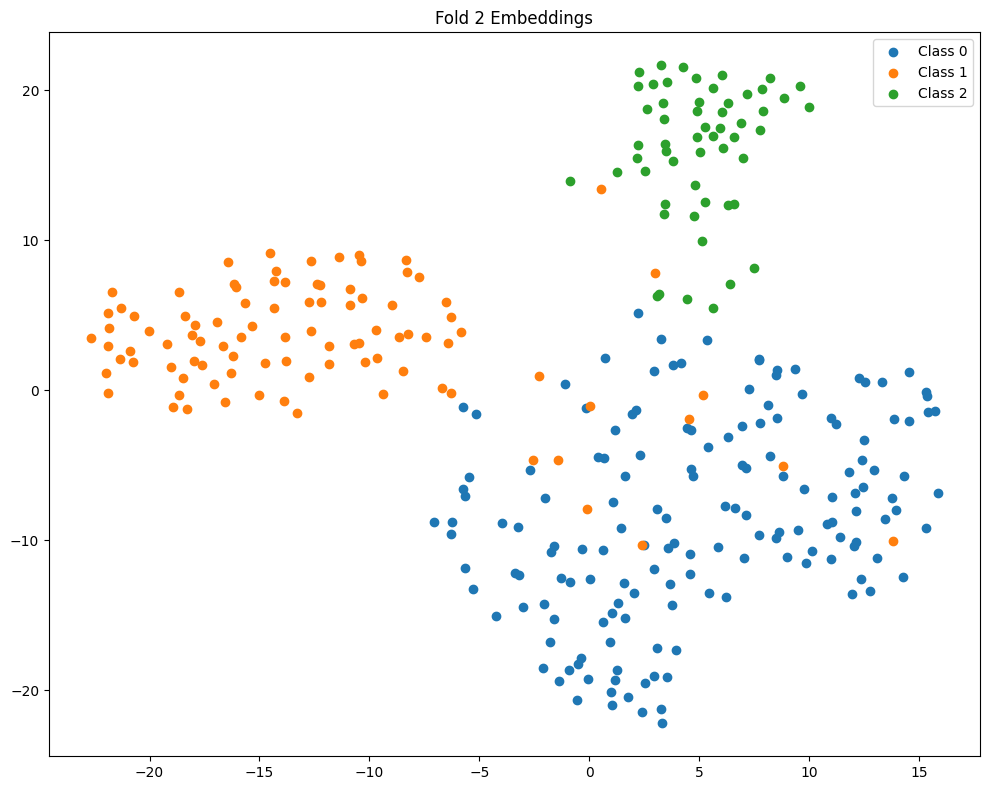

Fold 3: =========================================

EP 1/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.7212, CE Loss: 0.9127, Triplet Loss: 0.1286
Val AUC: 0.8636, CE Loss: 0.6460, Triplet Loss: 0.0041
New best AUC: 0.8636 at epoch 1.

EP 2/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.10it/s]


Train AUC: 0.8448, CE Loss: 0.6806, Triplet Loss: 0.1211
Val AUC: 0.9076, CE Loss: 0.5274, Triplet Loss: 0.0027
New best AUC: 0.9076 at epoch 2.
Warmup complete. Early stopping now active.

EP 3/50 (LR: 0.001650):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.7469, CE Loss: 0.8757, Triplet Loss: 0.1953
Val AUC: 0.8003, CE Loss: 0.8216, Triplet Loss: 0.0143

EP 4/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.8415, CE Loss: 0.6741, Triplet Loss: 0.1809
Val AUC: 0.8944, CE Loss: 0.5430, Triplet Loss: 0.0071

EP 5/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.8893, CE Loss: 0.5669, Triplet Loss: 0.1509
Val AUC: 0.9241, CE Loss: 0.4807, Triplet Loss: 0.0097
New best AUC: 0.9241 at epoch 5.

EP 6/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9022, CE Loss: 0.5304, Triplet Loss: 0.1356
Val AUC: 0.9406, CE Loss: 0.4077, Triplet Loss: 0.0102
New best AUC: 0.9406 at epoch 6.

EP 7/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9313, CE Loss: 0.4533, Triplet Loss: 0.1354
Val AUC: 0.9341, CE Loss: 0.4490, Triplet Loss: 0.0064

EP 8/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9449, CE Loss: 0.4071, Triplet Loss: 0.1171
Val AUC: 0.9524, CE Loss: 0.3697, Triplet Loss: 0.0047
New best AUC: 0.9524 at epoch 8.

EP 9/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9597, CE Loss: 0.3567, Triplet Loss: 0.1010
Val AUC: 0.9542, CE Loss: 0.3653, Triplet Loss: 0.0062
New best AUC: 0.9542 at epoch 9.

EP 10/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9699, CE Loss: 0.3062, Triplet Loss: 0.0980
Val AUC: 0.9587, CE Loss: 0.3486, Triplet Loss: 0.0059
New best AUC: 0.9587 at epoch 10.

EP 11/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9762, CE Loss: 0.2804, Triplet Loss: 0.0997
Val AUC: 0.9578, CE Loss: 0.3418, Triplet Loss: 0.0068

EP 12/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9757, CE Loss: 0.2830, Triplet Loss: 0.0808
Val AUC: 0.9588, CE Loss: 0.3336, Triplet Loss: 0.0058
New best AUC: 0.9588 at epoch 12.

EP 13/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9504, CE Loss: 0.3852, Triplet Loss: 0.1169
Val AUC: 0.9426, CE Loss: 0.4382, Triplet Loss: 0.0053

EP 14/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9636, CE Loss: 0.3219, Triplet Loss: 0.1105
Val AUC: 0.9534, CE Loss: 0.3668, Triplet Loss: 0.0060

EP 15/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9644, CE Loss: 0.3284, Triplet Loss: 0.0986
Val AUC: 0.9528, CE Loss: 0.4532, Triplet Loss: 0.0101

EP 16/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9825, CE Loss: 0.2379, Triplet Loss: 0.0791
Val AUC: 0.9751, CE Loss: 0.2761, Triplet Loss: 0.0077
New best AUC: 0.9751 at epoch 16.

EP 17/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9818, CE Loss: 0.2280, Triplet Loss: 0.0772
Val AUC: 0.9748, CE Loss: 0.2716, Triplet Loss: 0.0050

EP 18/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9843, CE Loss: 0.2136, Triplet Loss: 0.0727
Val AUC: 0.9709, CE Loss: 0.2990, Triplet Loss: 0.0023

EP 19/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9890, CE Loss: 0.1869, Triplet Loss: 0.0704
Val AUC: 0.9759, CE Loss: 0.2645, Triplet Loss: 0.0051
New best AUC: 0.9759 at epoch 19.

EP 20/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9932, CE Loss: 0.1478, Triplet Loss: 0.0390
Val AUC: 0.9792, CE Loss: 0.2571, Triplet Loss: 0.0025
New best AUC: 0.9792 at epoch 20.

EP 21/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9919, CE Loss: 0.1459, Triplet Loss: 0.0381
Val AUC: 0.9802, CE Loss: 0.2328, Triplet Loss: 0.0032
New best AUC: 0.9802 at epoch 21.

EP 22/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.12it/s]


Train AUC: 0.9921, CE Loss: 0.1522, Triplet Loss: 0.0425
Val AUC: 0.9823, CE Loss: 0.2211, Triplet Loss: 0.0031
New best AUC: 0.9823 at epoch 22.

EP 23/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:12<00:00,  2.11it/s]


Train AUC: 0.9858, CE Loss: 0.2013, Triplet Loss: 0.0683
Val AUC: 0.9586, CE Loss: 0.3925, Triplet Loss: 0.0077

EP 24/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.11it/s]


Train AUC: 0.9773, CE Loss: 0.2642, Triplet Loss: 0.0923
Val AUC: 0.9724, CE Loss: 0.2991, Triplet Loss: 0.0048

EP 25/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:14<00:00,  2.06it/s]


Train AUC: 0.9823, CE Loss: 0.2227, Triplet Loss: 0.0667
Val AUC: 0.9692, CE Loss: 0.3384, Triplet Loss: 0.0048

EP 26/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9917, CE Loss: 0.1651, Triplet Loss: 0.0521
Val AUC: 0.9711, CE Loss: 0.3110, Triplet Loss: 0.0076

EP 27/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.01it/s]


Train AUC: 0.9890, CE Loss: 0.1823, Triplet Loss: 0.0522
Val AUC: 0.9827, CE Loss: 0.2357, Triplet Loss: 0.0028
New best AUC: 0.9827 at epoch 27.

EP 28/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.01it/s]


Train AUC: 0.9935, CE Loss: 0.1367, Triplet Loss: 0.0475
Val AUC: 0.9820, CE Loss: 0.2236, Triplet Loss: 0.0073

EP 29/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:13<00:00,  2.08it/s]


Train AUC: 0.9940, CE Loss: 0.1180, Triplet Loss: 0.0366
Val AUC: 0.9852, CE Loss: 0.2108, Triplet Loss: 0.0023
New best AUC: 0.9852 at epoch 29.

EP 30/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9976, CE Loss: 0.0833, Triplet Loss: 0.0214
Val AUC: 0.9840, CE Loss: 0.2461, Triplet Loss: 0.0016

EP 31/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.9970, CE Loss: 0.0934, Triplet Loss: 0.0283
Val AUC: 0.9850, CE Loss: 0.2445, Triplet Loss: 0.0019

EP 32/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:20<00:00,  1.91it/s]


Train AUC: 0.9972, CE Loss: 0.0855, Triplet Loss: 0.0169
Val AUC: 0.9866, CE Loss: 0.1936, Triplet Loss: 0.0022
New best AUC: 0.9866 at epoch 32.

EP 33/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:18<00:00,  1.97it/s]


Train AUC: 0.9948, CE Loss: 0.1227, Triplet Loss: 0.0443
Val AUC: 0.9617, CE Loss: 0.4024, Triplet Loss: 0.0037

EP 34/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:18<00:00,  1.96it/s]


Train AUC: 0.9817, CE Loss: 0.2403, Triplet Loss: 0.0709
Val AUC: 0.9722, CE Loss: 0.4240, Triplet Loss: 0.0078

EP 35/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:19<00:00,  1.93it/s]


Train AUC: 0.9854, CE Loss: 0.1866, Triplet Loss: 0.0617
Val AUC: 0.9783, CE Loss: 0.2554, Triplet Loss: 0.0052

EP 36/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:18<00:00,  1.96it/s]


Train AUC: 0.9948, CE Loss: 0.1249, Triplet Loss: 0.0457
Val AUC: 0.9824, CE Loss: 0.2308, Triplet Loss: 0.0055

EP 37/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:17<00:00,  2.00it/s]


Train AUC: 0.9928, CE Loss: 0.1439, Triplet Loss: 0.0448
Val AUC: 0.9911, CE Loss: 0.1601, Triplet Loss: 0.0110
New best AUC: 0.9911 at epoch 37.

EP 38/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.00it/s]


Train AUC: 0.9961, CE Loss: 0.1048, Triplet Loss: 0.0277
Val AUC: 0.9875, CE Loss: 0.1971, Triplet Loss: 0.0046

EP 39/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.01it/s]


Train AUC: 0.9959, CE Loss: 0.1029, Triplet Loss: 0.0150
Val AUC: 0.9918, CE Loss: 0.1669, Triplet Loss: 0.0031
New best AUC: 0.9918 at epoch 39.

EP 40/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.02it/s]


Train AUC: 0.9988, CE Loss: 0.0650, Triplet Loss: 0.0187
Val AUC: 0.9898, CE Loss: 0.1847, Triplet Loss: 0.0028

EP 41/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9990, CE Loss: 0.0579, Triplet Loss: 0.0158
Val AUC: 0.9920, CE Loss: 0.1638, Triplet Loss: 0.0030
New best AUC: 0.9920 at epoch 41.

EP 42/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9978, CE Loss: 0.0696, Triplet Loss: 0.0166
Val AUC: 0.9927, CE Loss: 0.1628, Triplet Loss: 0.0034
New best AUC: 0.9927 at epoch 42.

EP 43/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9967, CE Loss: 0.0910, Triplet Loss: 0.0226
Val AUC: 0.9783, CE Loss: 0.2640, Triplet Loss: 0.0121

EP 44/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9878, CE Loss: 0.1970, Triplet Loss: 0.0594
Val AUC: 0.9878, CE Loss: 0.2434, Triplet Loss: 0.0035

EP 45/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9923, CE Loss: 0.1443, Triplet Loss: 0.0472
Val AUC: 0.9841, CE Loss: 0.2340, Triplet Loss: 0.0025

EP 46/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9961, CE Loss: 0.1127, Triplet Loss: 0.0457
Val AUC: 0.9873, CE Loss: 0.2167, Triplet Loss: 0.0038

EP 47/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.9965, CE Loss: 0.0910, Triplet Loss: 0.0344
Val AUC: 0.9914, CE Loss: 0.1671, Triplet Loss: 0.0072
Early stopping triggered at epoch 47
Best model saved: ../checkpoints\run1\fold3_best_auc0.9927_ep42.pth
Final model saved: ../checkpoints\run1\fold3_final.pth
History plot saved: ../checkpoints\run1\fold3_history.png


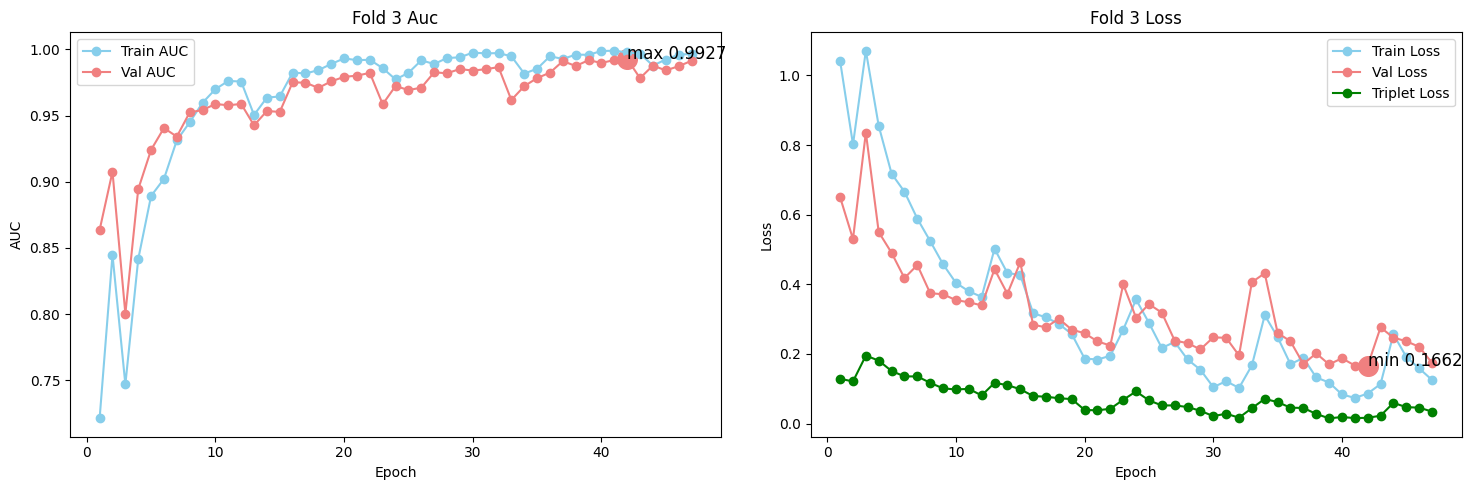

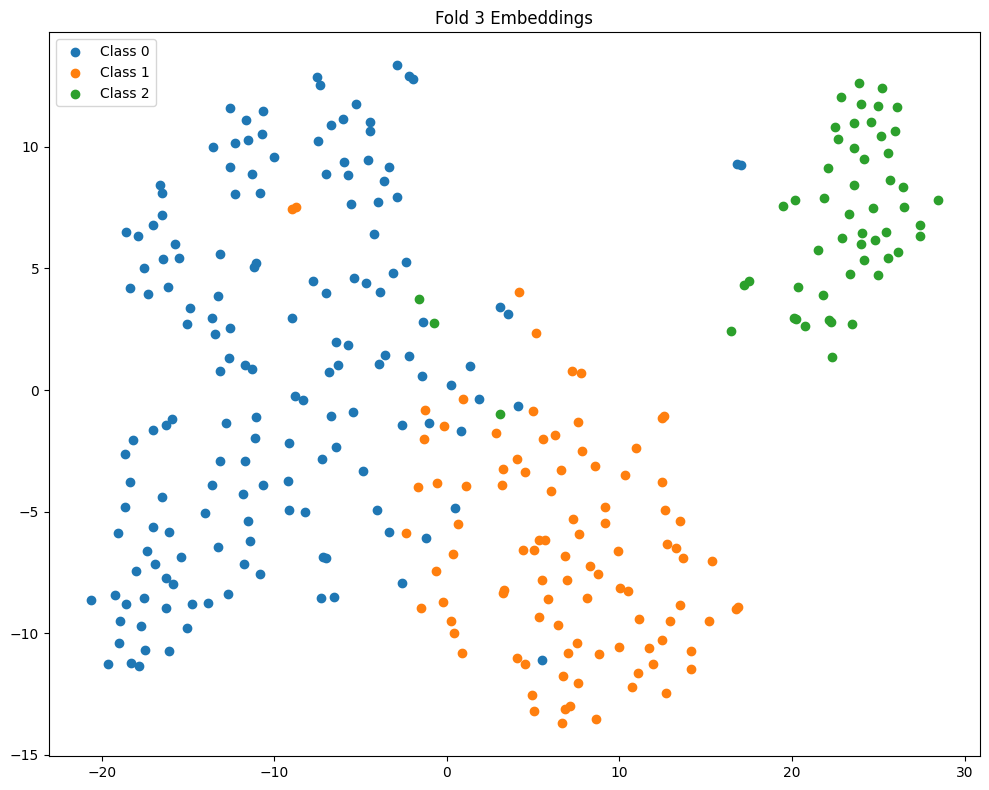

Fold 4: =========================================

EP 1/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:18<00:00,  1.96it/s]


Train AUC: 0.7212, CE Loss: 0.9090, Triplet Loss: 0.1505
Val AUC: 0.8153, CE Loss: 1.0864, Triplet Loss: 0.0049
New best AUC: 0.8153 at epoch 1.

EP 2/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.7938, CE Loss: 0.7654, Triplet Loss: 0.1317
Val AUC: 0.9112, CE Loss: 0.5993, Triplet Loss: 0.0029
New best AUC: 0.9112 at epoch 2.
Warmup complete. Early stopping now active.

EP 3/50 (LR: 0.001650):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.7573, CE Loss: 0.8480, Triplet Loss: 0.1871
Val AUC: 0.8439, CE Loss: 0.6764, Triplet Loss: 0.0075

EP 4/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.8715, CE Loss: 0.6114, Triplet Loss: 0.1477
Val AUC: 0.8872, CE Loss: 0.5754, Triplet Loss: 0.0097

EP 5/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.02it/s]


Train AUC: 0.9029, CE Loss: 0.5425, Triplet Loss: 0.1570
Val AUC: 0.9392, CE Loss: 0.4228, Triplet Loss: 0.0058
New best AUC: 0.9392 at epoch 5.

EP 6/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.9303, CE Loss: 0.4601, Triplet Loss: 0.1297
Val AUC: 0.9063, CE Loss: 0.5538, Triplet Loss: 0.0076

EP 7/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.9551, CE Loss: 0.3730, Triplet Loss: 0.1249
Val AUC: 0.9282, CE Loss: 0.4807, Triplet Loss: 0.0076

EP 8/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9577, CE Loss: 0.3605, Triplet Loss: 0.1133
Val AUC: 0.9537, CE Loss: 0.3656, Triplet Loss: 0.0099
New best AUC: 0.9537 at epoch 8.

EP 9/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.9637, CE Loss: 0.3329, Triplet Loss: 0.0887
Val AUC: 0.9644, CE Loss: 0.3290, Triplet Loss: 0.0072
New best AUC: 0.9644 at epoch 9.

EP 10/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9802, CE Loss: 0.2517, Triplet Loss: 0.0873
Val AUC: 0.9650, CE Loss: 0.3258, Triplet Loss: 0.0086
New best AUC: 0.9650 at epoch 10.

EP 11/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9779, CE Loss: 0.2605, Triplet Loss: 0.0757
Val AUC: 0.9718, CE Loss: 0.2971, Triplet Loss: 0.0068
New best AUC: 0.9718 at epoch 11.

EP 12/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9853, CE Loss: 0.2274, Triplet Loss: 0.0765
Val AUC: 0.9758, CE Loss: 0.2740, Triplet Loss: 0.0052
New best AUC: 0.9758 at epoch 12.

EP 13/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9599, CE Loss: 0.3555, Triplet Loss: 0.1162
Val AUC: 0.9498, CE Loss: 0.5124, Triplet Loss: 0.0064

EP 14/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9668, CE Loss: 0.3218, Triplet Loss: 0.0981
Val AUC: 0.9660, CE Loss: 0.3459, Triplet Loss: 0.0056

EP 15/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9724, CE Loss: 0.2945, Triplet Loss: 0.1061
Val AUC: 0.9804, CE Loss: 0.2380, Triplet Loss: 0.0054
New best AUC: 0.9804 at epoch 15.

EP 16/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9800, CE Loss: 0.2454, Triplet Loss: 0.0772
Val AUC: 0.9699, CE Loss: 0.3024, Triplet Loss: 0.0067

EP 17/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9828, CE Loss: 0.2190, Triplet Loss: 0.0743
Val AUC: 0.9640, CE Loss: 0.3396, Triplet Loss: 0.0066

EP 18/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9890, CE Loss: 0.1819, Triplet Loss: 0.0577
Val AUC: 0.9817, CE Loss: 0.2487, Triplet Loss: 0.0045
New best AUC: 0.9817 at epoch 18.

EP 19/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9940, CE Loss: 0.1389, Triplet Loss: 0.0434
Val AUC: 0.9860, CE Loss: 0.2113, Triplet Loss: 0.0048
New best AUC: 0.9860 at epoch 19.

EP 20/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9972, CE Loss: 0.1075, Triplet Loss: 0.0333
Val AUC: 0.9865, CE Loss: 0.2068, Triplet Loss: 0.0050
New best AUC: 0.9865 at epoch 20.

EP 21/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9938, CE Loss: 0.1387, Triplet Loss: 0.0318
Val AUC: 0.9861, CE Loss: 0.2116, Triplet Loss: 0.0045

EP 22/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9968, CE Loss: 0.0992, Triplet Loss: 0.0277
Val AUC: 0.9880, CE Loss: 0.1849, Triplet Loss: 0.0035
New best AUC: 0.9880 at epoch 22.

EP 23/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9831, CE Loss: 0.2234, Triplet Loss: 0.0637
Val AUC: 0.9707, CE Loss: 0.3041, Triplet Loss: 0.0040

EP 24/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9844, CE Loss: 0.2180, Triplet Loss: 0.0757
Val AUC: 0.9170, CE Loss: 0.6817, Triplet Loss: 0.0063

EP 25/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9852, CE Loss: 0.2133, Triplet Loss: 0.0713
Val AUC: 0.9814, CE Loss: 0.2606, Triplet Loss: 0.0009

EP 26/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9941, CE Loss: 0.1407, Triplet Loss: 0.0452
Val AUC: 0.9816, CE Loss: 0.2394, Triplet Loss: 0.0081

EP 27/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9937, CE Loss: 0.1353, Triplet Loss: 0.0579
Val AUC: 0.9897, CE Loss: 0.1715, Triplet Loss: 0.0004
New best AUC: 0.9897 at epoch 27.

EP 28/50 (LR: 0.000150):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.03it/s]


Train AUC: 0.9933, CE Loss: 0.1306, Triplet Loss: 0.0271
Val AUC: 0.9883, CE Loss: 0.1954, Triplet Loss: 0.0050

EP 29/50 (LR: 0.000104):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9979, CE Loss: 0.0800, Triplet Loss: 0.0261
Val AUC: 0.9878, CE Loss: 0.1900, Triplet Loss: 0.0059

EP 30/50 (LR: 0.000062):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9956, CE Loss: 0.1044, Triplet Loss: 0.0264
Val AUC: 0.9915, CE Loss: 0.1480, Triplet Loss: 0.0020
New best AUC: 0.9915 at epoch 30.

EP 31/50 (LR: 0.000029):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9984, CE Loss: 0.0769, Triplet Loss: 0.0129
Val AUC: 0.9906, CE Loss: 0.1555, Triplet Loss: 0.0046

EP 32/50 (LR: 0.000007):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9962, CE Loss: 0.0961, Triplet Loss: 0.0167
Val AUC: 0.9918, CE Loss: 0.1475, Triplet Loss: 0.0033
New best AUC: 0.9918 at epoch 32.

EP 33/50 (LR: 0.000300):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9899, CE Loss: 0.1643, Triplet Loss: 0.0547
Val AUC: 0.9760, CE Loss: 0.3073, Triplet Loss: 0.0050

EP 34/50 (LR: 0.000293):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9901, CE Loss: 0.1651, Triplet Loss: 0.0413
Val AUC: 0.9844, CE Loss: 0.2268, Triplet Loss: 0.0014

EP 35/50 (LR: 0.000271):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9894, CE Loss: 0.1752, Triplet Loss: 0.0557
Val AUC: 0.9889, CE Loss: 0.1878, Triplet Loss: 0.0038

EP 36/50 (LR: 0.000238):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.05it/s]


Train AUC: 0.9951, CE Loss: 0.1242, Triplet Loss: 0.0398
Val AUC: 0.9829, CE Loss: 0.2620, Triplet Loss: 0.0083

EP 37/50 (LR: 0.000196):


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


Train AUC: 0.9979, CE Loss: 0.0847, Triplet Loss: 0.0351
Val AUC: 0.9829, CE Loss: 0.2792, Triplet Loss: 0.0061
Early stopping triggered at epoch 37
Best model saved: ../checkpoints\run1\fold4_best_auc0.9918_ep32.pth
Final model saved: ../checkpoints\run1\fold4_final.pth
History plot saved: ../checkpoints\run1\fold4_history.png


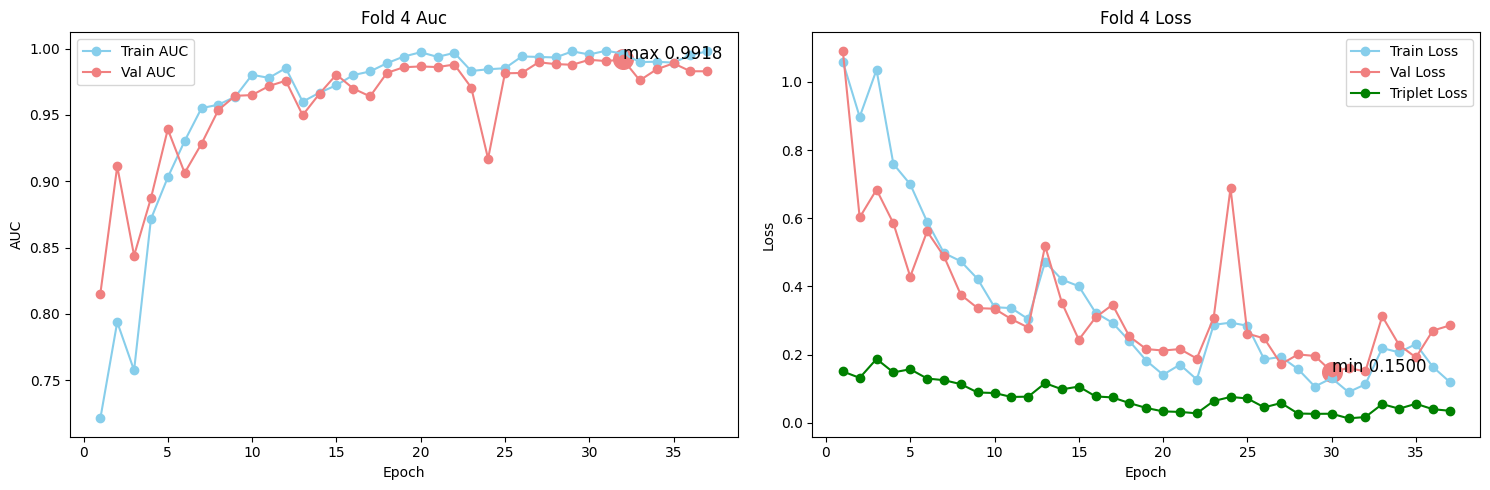

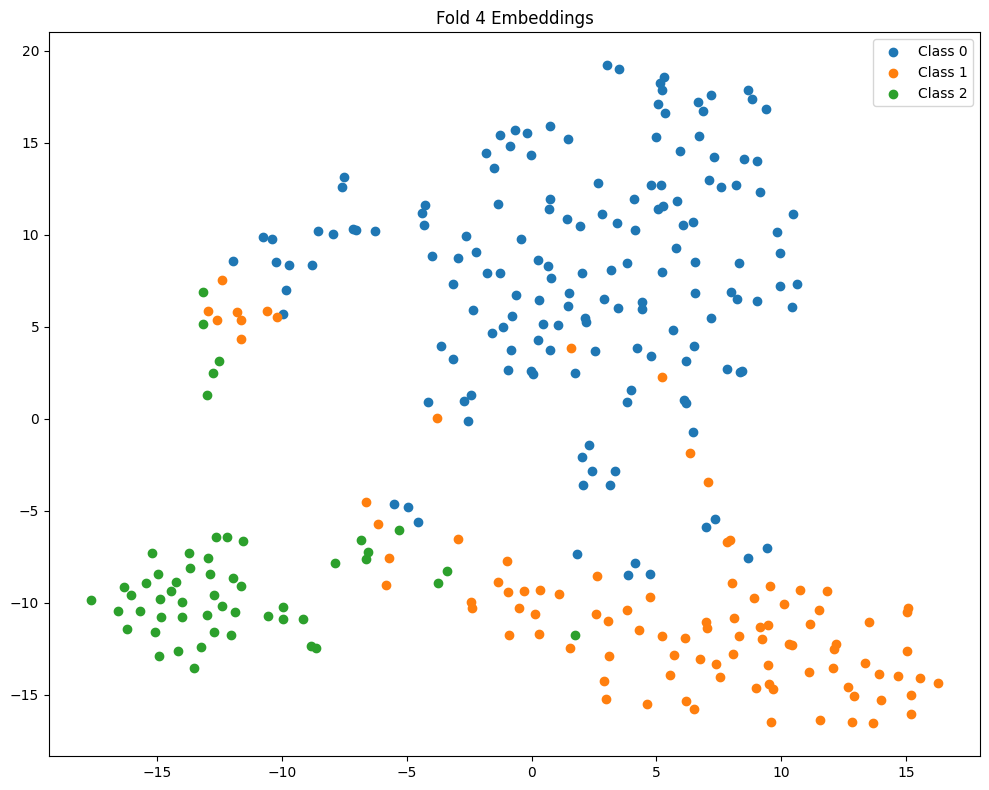

Overall OOF AUC = 0.981
OOF saved to: ../checkpoints\run1\oof_triplet.csv
                                          image_name  target  fold  \
0  normal\02520bf4-a006-4bad-9d67-5f33a9f3a3ac.23...       0     0   
1  normal\02520bf4-a006-4bad-9d67-5f33a9f3a3ac.25...       0     0   
2  normal\02520bf4-a006-4bad-9d67-5f33a9f3a3ac.27...       0     0   
3  normal\02520bf4-a006-4bad-9d67-5f33a9f3a3ac.28...       0     0   
4  normal\02520bf4-a006-4bad-9d67-5f33a9f3a3ac.3.jpg       0     0   

   prob_normal  prob_preplus     prob_plus  
0     0.622640      0.377355  4.757676e-06  
1     0.997246      0.002681  7.320118e-05  
2     0.994322      0.005643  3.495028e-05  
3     0.998145      0.001831  2.496318e-05  
4     0.996062      0.003938  3.855120e-07  


In [7]:
IMG_SIZE=512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8
n_epochs = 50
num_workers = 0
print(f"Num workers = {num_workers}")
folds=[0,1,2,3,4]
lr = 3e-4
backbone_name='resnet101'

checkpoint_dir = '../checkpoints'
run_num = 1
while True:
    run_dir = os.path.join(checkpoint_dir, f"run{run_num}")
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
        break
    run_num += 1
print(f"Checkpoints will be saved in: {run_dir}")

oof_preds_all = []
oof_targets_all = []
oof_names_all = []
oof_folds_all = []
oof_embeddings_all = []

transforms_train, transforms_val = get_transforms(IMG_SIZE)

for fold in folds:
    oof_preds, oof_targets, oof_names, oof_folds, oof_embeddings = run(
        fold, df, root_dir, transforms_train, transforms_val, num_workers, n_epochs, device, batch_size, lr, run_dir, backbone_name
    )
    oof_preds_all.append(oof_preds)
    oof_targets_all.append(oof_targets)
    oof_names_all.append(oof_names)
    oof_folds_all.append(oof_folds)
    oof_embeddings_all.append(oof_embeddings)
    
    # Visualize embeddings for this fold
    visualize_embeddings(oof_embeddings, oof_targets, f"Fold {fold} Embeddings", run_dir)

# Concatenate OOF data
oof_preds_all = np.concatenate(oof_preds_all)
oof_targets_all = np.concatenate(oof_targets_all)
oof_names_all = np.concatenate(oof_names_all)
oof_folds_all = np.concatenate(oof_folds_all)
oof_embeddings_all = np.concatenate(oof_embeddings_all)

# Visualize all embeddings together
# visualize_embeddings(oof_embeddings_all, oof_targets_all, "All Folds Embeddings", run_dir)

# Compute overall OOF AUC
auc = roc_auc_score(oof_targets_all, oof_preds_all, multi_class='ovr')
print(f'Overall OOF AUC = {auc:.3f}')

# Save OOF to CSV with class probabilities
# Create a dictionary for the DataFrame
df_oof_dict = {
    'image_name': oof_names_all,
    'target': oof_targets_all,
    'fold': oof_folds_all
}

# Add probability columns for each class
for i, class_name in enumerate(class_list):
    df_oof_dict[f'prob_{class_name}'] = oof_preds_all[:, i]

# Create DataFrame
df_oof = pd.DataFrame(df_oof_dict)

# Save to run_dir
oof_path = os.path.join(run_dir, 'oof_triplet.csv')
df_oof.to_csv(oof_path, index=False)
print(f"OOF saved to: {oof_path}")
print(df_oof.head())